In [1]:
%load_ext autoreload
%autoreload 2

In [75]:
from skimage.transform import AffineTransform
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import z5py
import re
from typing import Dict, List

In [3]:
from cryofib.n5_utils import read_volume, tif2n5

# Set paths

In [4]:
scratch_dir = Path("/scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem")
fluo_dir = scratch_dir / "fluo"
em_dir = scratch_dir / "em"
segm_em_nuclei_dir = scratch_dir / "segm_em_nuclei"

## Convert tif to n5 files

In [65]:
tif2n5(tif_dir=em_dir,
        n5_path=em_dir / "em.n5",
        n5_key="raw",
        reg_exp="*.tiff",
        description="Raw em data transposed to match fluorescence coordinates (xyz --> yzx)",
        order="zyx",
        unit="nm",
        resolution=(30, 40, 30),
        roi=None)

Reading tif files from /scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/em
Read (1410, 1386, 1610) of type uint8
Writing to /scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/em/em.n5, key raw
Assigning attributes of the dataset


In [6]:
# tif2n5(tif_dir=segm_em_nuclei_dir,
#         n5_path=segm_em_nuclei_dir / "em_nuclei.n5",
#         n5_key="raw",
#         reg_exp="*.tiff",
#         description="Raw em data transposed to match fluorescence coordinates (xyz --> yzx)",
#         order="zyx",
#         unit="nm",
#         resolution=(30, 40, 30),
#         roi=None)

In [7]:
# tif2n5(tif_dir=fluo_dir,
#         n5_path=fluo_dir / "fluo.n5",
#         n5_key="raw",
#         reg_exp="*.tiff",
#         description="Raw fluorescence data",
#         order="zyx",
#         unit="nm",
#         resolution=(1849.5, 221.4, 221.4),
#         roi=None)

## Load n5

In [8]:
scratch_dir = Path("/scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem")
fluo_dir = scratch_dir / "fluo"
em_dir = scratch_dir / "em"
segm_em_nuclei_dir = scratch_dir / "segm_em_nuclei"
alignment_points_path = scratch_dir / "Probe_coordinates_for_Alyona.txt"

In [9]:
fluo_path = fluo_dir / "fluo.n5"
em_path = em_dir / "em.n5"
segm_em_nuclei_path = segm_em_nuclei_dir / "em_nuclei.n5"

In [10]:
f_fluo = z5py.File(fluo_path, "r")
f_em = z5py.File(em_path, "r")
f_segm_em_nuclei = z5py.File(segm_em_nuclei_path, "r")

In [11]:
roi = np.s_[:]
fluo = read_volume(f_fluo, "raw", roi)
em = read_volume(f_em, "raw", roi)
segm_em_nuclei = read_volume(f_segm_em_nuclei, "raw", roi)

Reading roi slice(None, None, None) of volume raw from /scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/fluo/fluo.n5
Read volume with shape (55, 3343, 1482), data type uint8
No key raw in file /scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/em/em.n5
Key structure of z5 file /scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/em/em.n5
Reading roi slice(None, None, None) of volume raw from /scratch/buglakova/data/cryofib/registration_fluo/F107_A2_3dclem/segm_em_nuclei/em_nuclei.n5
Read volume with shape (1410, 1386, 1610), data type uint8


In [12]:
image_names = {"fluo": "HT6_3Dcrop",
                "em": "F107_a2_ali_crop_from70_bin2_ORS-denoised_YZX"}
with open(alignment_points_path, "r") as f:
    text = f.read()
    # print(repr(text))
    for ds in image_names.keys():
        print(ds)
        points = re.compile(r"Image: %s\n  Value: \d*\n  Voxel: x:\d* y:\d* z:\d*"%image_names[ds], re.MULTILINE)
        for point in points.findall(text):
            regexp_coords = re.compile(r"Value: (?P<val>\d*)\n  Voxel: x:(?P<x>\d*) y:(?P<y>\d*) z:(?P<z>\d*)")
            m = regexp_coords.search(point)
            print(m.groupdict())
            

fluo
{'val': '156', 'x': '458', 'y': '498', 'z': '4'}
{'val': '159', 'x': '462', 'y': '747', 'z': '7'}
{'val': '148', 'x': '431', 'y': '569', 'z': '10'}
{'val': '112', 'x': '445', 'y': '548', 'z': '14'}
{'val': '52', 'x': '553', 'y': '667', 'z': '1'}
{'val': '125', 'x': '433', 'y': '569', 'z': '11'}
em
{'val': '103', 'x': '70', 'y': '890', 'z': '686'}
{'val': '124', 'x': '1443', 'y': '725', 'z': '833'}
{'val': '131', 'x': '478', 'y': '1035', 'z': '1082'}
{'val': '66', 'x': '359', 'y': '933', 'z': '1312'}
{'val': '101', 'x': '959', 'y': '116', 'z': '439'}
{'val': '114', 'x': '478', 'y': '1018', 'z': '1116'}


In [20]:
def dict_to_np(parsed_dict):
    """
    Dragonfly has numbering starting from 1 instead of 0, so -1
    For Mobie axis order is zyx
    """
    val = int(parsed_dict["val"])
    coords = [parsed_dict["z"], parsed_dict["y"], parsed_dict["x"]]
    coords = [int(coord) - 1 for coord in coords]
    return coords

def parse_points(dragonfly_output_path: Path, image_names: Dict):
    coords = {}
    with open(dragonfly_output_path, "r") as f:
        text = f.read()
        # print(repr(text))
        for ds in image_names.keys():
            print(ds)
            ds_coords = []
            points = re.compile(r"Image: %s\n  Value: \d*\n  Voxel: x:\d* y:\d* z:\d*"%image_names[ds], re.MULTILINE)
            for point in points.findall(text):
                regexp_coords = re.compile(r"Value: (?P<val>\d*)\n  Voxel: x:(?P<x>\d*) y:(?P<y>\d*) z:(?P<z>\d*)")
                m = regexp_coords.search(point)
                print(m.groupdict())
                ds_coords.append(dict_to_np(m.groupdict()))
            ds_coords = np.array(ds_coords)
            coords[ds] = ds_coords
    return coords

            

In [21]:
image_names = {"fluo": "HT6_3Dcrop",
                "em": "F107_a2_ali_crop_from70_bin2_ORS-denoised_YZX"}

coords = parse_points(alignment_points_path, image_names)

fluo
{'val': '156', 'x': '458', 'y': '498', 'z': '4'}
{'val': '159', 'x': '462', 'y': '747', 'z': '7'}
{'val': '148', 'x': '431', 'y': '569', 'z': '10'}
{'val': '112', 'x': '445', 'y': '548', 'z': '14'}
{'val': '52', 'x': '553', 'y': '667', 'z': '1'}
{'val': '125', 'x': '433', 'y': '569', 'z': '11'}
em
{'val': '103', 'x': '70', 'y': '890', 'z': '686'}
{'val': '124', 'x': '1443', 'y': '725', 'z': '833'}
{'val': '131', 'x': '478', 'y': '1035', 'z': '1082'}
{'val': '66', 'x': '359', 'y': '933', 'z': '1312'}
{'val': '101', 'x': '959', 'y': '116', 'z': '439'}
{'val': '114', 'x': '478', 'y': '1018', 'z': '1116'}


In [22]:
coords

{'fluo': array([[  3, 497, 457],
        [  6, 746, 461],
        [  9, 568, 430],
        [ 13, 547, 444],
        [  0, 666, 552],
        [ 10, 568, 432]]),
 'em': array([[ 685,  889,   69],
        [ 832,  724, 1442],
        [1081, 1034,  477],
        [1311,  932,  358],
        [ 438,  115,  958],
        [1115, 1017,  477]])}

## Affine transform

Transform should consist of 
- translation along all axes  
- rotation only around Z (within the plane where fluorescence has good resolution) and around Y (within the plane where FIB-SEM has the best resolution). The other angle is probably impossible to get right, because during acquizition there is already some rotation and then it's taken into account already, and there is not enough resolution for it anyway.

So to parametrize the rotation in terms of euler angles, it makes sense to rotate first around Y, then around Z

Prior to this affine transform there is a scaling step to bring both volumes to the same resolution? --> set based on resolution of the datasets

In [23]:
from transforms3d.euler import euler2mat, mat2euler

In [74]:
np.diag(f_em["raw"].attrs["resolution"])

array([[30,  0,  0],
       [ 0, 40,  0],
       [ 0,  0, 30]])

In [61]:
R = euler2mat(0, 0, -np.pi * 0.5, 'syxz')
arr = coords["em"].T
rotated = np.dot(R, arr)

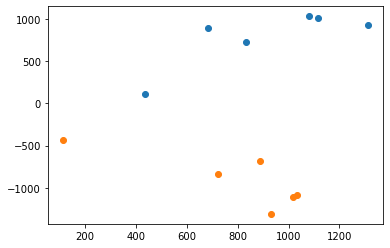

In [62]:
plt.scatter(arr[0, :], arr[1, :])
plt.scatter(rotated[0, :], rotated[1, :])

In [88]:
def get_scaling_transform(resolution: List):
    """translation
    Get scaling matrix: 4x4 matrix with scaling factors on diagonal
    resolution: pixel sizes for each axis
    """
    resolution = list(resolution)
    return np.diag(resolution + [1])

def get_translation_transform(translation):
    M = np.identity(4)
    M[0:3, 3] = translation
    return M

def get_affine_transform(translation, rotation):
    M = get_translation_transform(translation)
    M[0:3, 0:3] = euler2mat(*rotation, 'syxz')
    return M

In [89]:
get_affine_transform([1, 2, 3], [0, 0, -np.pi * 0.5])

array([[ 6.123234e-17,  1.000000e+00,  0.000000e+00,  1.000000e+00],
       [-1.000000e+00,  6.123234e-17,  0.000000e+00,  2.000000e+00],
       [ 0.000000e+00, -0.000000e+00,  1.000000e+00,  3.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [86]:
get_translation_transform([1, 2, 1])

array([[1., 0., 0., 1.],
       [0., 1., 0., 2.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])

In [79]:
get_scaling_transform(f_em["raw"].attrs["resolution"])

array([[30,  0,  0,  0],
       [ 0, 40,  0,  0],
       [ 0,  0, 30,  0],
       [ 0,  0,  0,  1]])

In [90]:
from scipy.optimize import minimize

In [138]:
def params_to_transform(x):
    t_x, t_y, t_z = x[0], x[1], x[2]
    phi_y, phi_z = x[3], x[4]
    R = get_affine_transform([t_x, t_y, t_z], [0, phi_y, phi_z])
    return R

def objective_function(x, ref_points, moving_points):
    """
    x = [t_x, t_y, t_z, phi_y, phi_z]
    """
    R = params_to_transform(x)
    new_points = np.dot(R, moving_points)[0:3, :]
    dist = np.sqrt(np.sum((new_points - ref_points[0:3, :])**2,axis=0))
    print(dist)
    
    return np.sum(dist)  

In [167]:
def fit_affine_transform(ref_points, moving_points, ref_res, moving_res):
    ref_points = np.vstack([ref_points, np.ones(ref_points.shape[1])])
    S_ref = get_scaling_transform(ref_res)
    ref_points = np.dot(S_ref, ref_points)

    moving_points = np.vstack([moving_points, np.ones(moving_points.shape[1])])
    S_moving = get_scaling_transform(moving_res)
    moving_points = np.dot(S_moving, moving_points)

    # Plot points
    plt.scatter(ref_points[2, :], ref_points[0, :], label="ref")
    plt.scatter(moving_points[2, :], moving_points[0, :], label="move")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    

    t_0 = np.mean(ref_points, axis=1) - np.mean(moving_points, axis=1)
    print(t_0)
    res = minimize(objective_function, [t_0[0], t_0[1], t_0[2], 0, 0], args=(ref_points, moving_points))

    print(res.success)
    print(res.x)

    R = params_to_transform(res.x)
    new_points = np.dot(R, moving_points)[0:3, :]
    plt.scatter(new_points[2, :], new_points[0, :], label="new")

    plt.show()

    
    return ref_points, moving_points, new_points, res.x, R

[-14671.75       101138.13333333  83529.4             0.        ]
[30882.64266542 42913.55625557 16985.87377579 17786.32732879
 42910.34263625 16214.63311314]
[30882.64266542 42913.55625557 16985.87377579 17786.32732879
 42910.34263625 16214.63311314]
[30882.64266544 42913.55625556 16985.8737758  17786.32732881
 42910.34263623 16214.63311315]
[30882.64266542 42913.55625558 16985.87377579 17786.32732879
 42910.34263625 16214.63311314]
[30882.64237147 42913.55703094 16985.8736613  17786.32704708
 42910.34303669 16214.63298394]
[30882.64292414 42913.55595979 16985.87421174 17786.32788004
 42910.34244835 16214.63359633]
[32983.13150259 67410.57946497 36489.07257826 37257.70774975
 51781.21877622 36360.6845391 ]
[32983.1315026  67410.57946498 36489.07257827 37257.70774975
 51781.21877622 36360.68453911]
[32983.13150259 67410.57946496 36489.07257825 37257.70774974
 51781.21877621 36360.68453909]
[32983.13150258 67410.57946498 36489.07257826 37257.70774974
 51781.21877622 36360.68453909]
[329

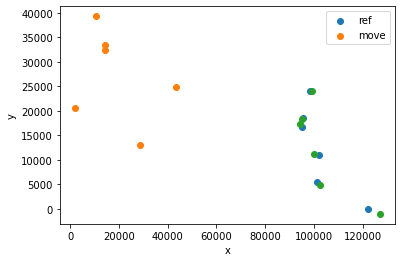

In [169]:
ref_points = coords["fluo"].T
moving_points = coords["em"].T

ref_points, moving_points, new_points, x, R = fit_affine_transform(ref_points, moving_points, f_fluo["raw"].attrs["resolution"], f_em["raw"].attrs["resolution"])

In [154]:
print(R)

[[ 9.99010743e-01 -9.68391535e-03  4.34022672e-02 -1.53353979e+04]
 [-4.44694841e-02 -2.17549982e-01  9.75035625e-01  1.21702925e+05]
 [-0.00000000e+00 -9.76001141e-01 -2.17765408e-01  1.37783569e+05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Text(0, 0.5, 'y')

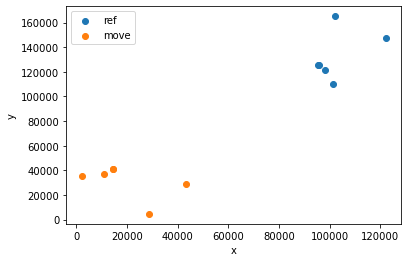

In [171]:
plt.scatter(ref_points[2, :], ref_points[1, :], label="ref")
plt.scatter(moving_points[2, :], moving_points[1, :], label="move")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

Text(0, 0.5, 'y')

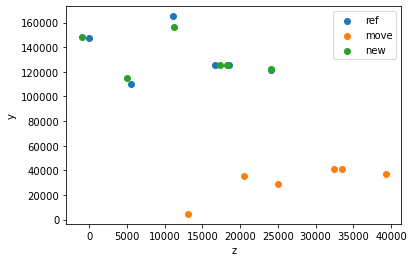

In [174]:
plt.scatter(ref_points[0, :], ref_points[1, :], label="ref")
plt.scatter(moving_points[0, :], moving_points[1, :], label="move")
plt.scatter(new_points[0, :], new_points[1, :], label="new")
plt.legend()
plt.xlabel("z")
plt.ylabel("y")

In [162]:
R_scale = R.copy()

In [175]:
print(R)

[[ 9.99010743e-01 -9.68391535e-03  4.34022672e-02 -1.53353979e+04]
 [-4.44694841e-02 -2.17549982e-01  9.75035625e-01  1.21702925e+05]
 [-0.00000000e+00 -9.76001141e-01 -2.17765408e-01  1.37783569e+05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [163]:
for i in range(len(f_em["raw"].attrs["resolution"])):
    R_scale[:, i] *= f_em["raw"].attrs["resolution"][i]
    # R_scale[i, 3] *= f_em["raw"].attrs["resolution"][i]

In [164]:
f_em["raw"].attrs["resolution"]

[30, 40, 30]

In [165]:
print(R_scale)

[[ 2.99703223e+01 -3.87356614e-01  1.30206802e+00 -1.53353979e+04]
 [-1.33408452e+00 -8.70199929e+00  2.92510688e+01  1.21702925e+05]
 [-0.00000000e+00 -3.90400456e+01 -6.53296224e+00  1.37783569e+05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [176]:
print(np.linalg.inv(R_scale))

[[ 3.33003581e-02 -1.48231614e-03  3.10639515e-20  6.91076451e+02]
 [-2.42097884e-04 -5.43874955e-03 -2.44000285e-02  4.02012209e+03]
 [ 1.44674224e-03  3.25011875e-02 -7.25884694e-03 -2.93315338e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
